In [1]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
from scipy import stats
import pandas as pd
import sympy as sym
%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
import seaborn as sns
import os
from scipy.stats import anderson
from scipy.stats import kstest
from scipy.stats import shapiro 
#to en otra carpeta


# Se analiza la situación con CdSe

In [2]:
# Función ajustar
def fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T

# Función ajustar
def BETA(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    # Transmitance
    b=(1-trans)*(1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2))**-1
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b


def ruido(señal,desv): 
    '''
    Función para añadir ruido Gaussiano dada una desviación estandar

    Parametros
    ----------
    señal: Arreglo
      Arreglo con la señal a la que se le va añadir el ruido
    desv: float
      Desviación estandar
    '''
    señal_ruido=[np.random.normal(señal[i], señal[i]*desv) for i in range(0,len(señal))]
    return np.array(señal_ruido)

def central(s,k):

    '''
    Funcion para verificar teorema del limite central

    Parametros
    -----------
    s: Arreglo
     Arreglo de datos a los que se quieren aplicar el teorema
    k: float
     Numero de datos para efectuar el promedio

'''

    new_s=[]

    for i in range(0,len(s)):
        new_s.append(np.mean(np.random.choice(s,size=k)))
    return new_s

def confirm_gauss(s):
    result = (anderson(np.sort(s), dist='norm'))
    criterio=((result[0]<result[1][3])or(shapiro(np.sort(s))[1]>0.05))*1   
    return criterio
    


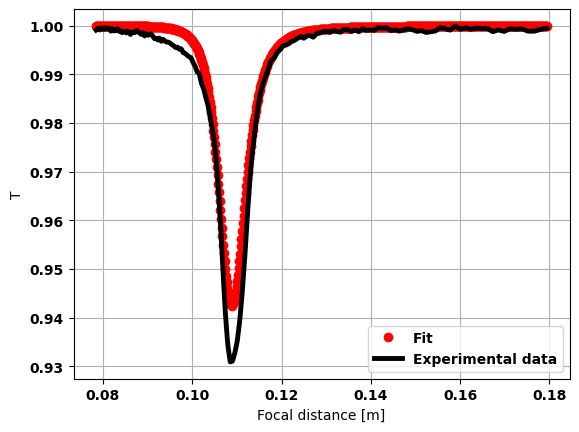

In [3]:
# Datos reportados:
L= 0.79e-3 # thickness in (m).
Pavg = 145e-3# Average power in (W)
Tp = 71e-15 # pulse width FWHM in (s)
wl =790e-9 #central wavelength in (m)
D = 2e-3 # beam diameter in (m)
ds = 109.0e-3# Distance EFTL-sample (m)a
Cf = 1.36 # beam correction coeff
alfa = 369 # linear absorption in (1/m) 
R =0.185 # reflection percentage 
freq = 90.6e6#Frecuencia en HZ

datos=np.loadtxt('CdSe-data-corr-TFscan-FIT.txt')
focal=datos[:,0]
T_e=list(datos[:,1])
index=T_e.index(min(T_e))
T_a=datos[:,2]

t_t= fscanTH2(focal,3e-11,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)

#plt.plot(focal,T_a,'ro',label='fitting data')
plt.plot(focal,t_t,'ro',label='Fit')
plt.plot(focal,T_e,'k',label='Experimental data',linewidth=3.5)
plt.legend()
plt.xlabel('Focal distance [m]')
plt.ylabel('T')
plt.grid()

In [4]:
def dist_betas(N,par,desv): 
    '''
    Parametros
    ----------
    N: float
        Numero de valores con los que se va a formar el histograma
    desv: float
        Arreglo con distancias focales utilizadas.
    k: float
        indice del arreglo de la distancia focal.
    par: array
        arreglo de 0 o 1 dependiendo de cual parametro se quiera investigar.
        [L,P,T,wl,D,ds,Cf,alpha,R,freq,trans,focal]

    La función devuelve la distribucion de beta
    '''
  # Cont,edra valores de TPA
    TPA=[]
    trans=T_e[index] #Minimo de la señal simulada. 
    f=focal[index]  #Distancia focal correspondiente al minimo.   
    er_L=0.01e-3*par[0]
    er_P=5e-3*par[1]
    er_T=0.3e-15*par[2]
    er_wl=1e-9*par[3]
    er_D=desv*par[4]
    er_ds=0.5e-3*par[5]
    er_Cf=0.04*par[6]
    er_a=37*par[7]
    er_R=0.005*par[8]
    er_freq=0
    er_trans=0
    er_focal=0
    # Randomly c
    for ii in range(N):


        L_f = np.random.normal(L,er_L,1) # # thickness in (m).
        Pavg_f = np.random.normal(Pavg,er_P,1) # Average power in (W)
        Tp_f = abs(np.random.normal(Tp,er_T,1)) # Pulse width FWHM in (s). sech
        wl_f = np.random.normal(wl,er_wl,1) #central wavelength in (m)
        D_f = np.random.normal(D,er_D,1) # beam diameter in (m)
        ds_f = np.random.normal(ds,er_ds,1) # EFTL-sample distance (m)
        Cf_f = np.random.normal(Cf,er_Cf,1) # Beam correction factor
        alfa_f =  abs(np.random.normal(alfa,er_a,1)) #linear absorption (1/m)
        R_f = np.random.normal(R,er_R,1) # Reflectance
        freq_f = np.random.normal(freq,er_freq,1) # Reflectance
        trans_f= np.random.normal(trans,er_trans,1)
        focal_f=np.random.normal(f,er_focal,1) 
        TPA.append(BETA(trans_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,ds_f,Cf_f,alfa_f,R_f,freq_f)[0])
      
    
    return TPA




In [5]:
L_s, P_s,Tp_s,wl_s,D_s,ds_s,Cf_s,alfa_s,R_s,v_s,T_s,f_s = sym.symbols('L P Tp wl D ds Cf alpha R v T f')
params_s=[L_s, P_s,Tp_s,wl_s,D_s,ds_s,Cf_s,alfa_s,R_s,v_s,T_s,f_s]

# Función ajustar
def BETA_S(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - sym.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(sym.pi*D) # beam waist
    z0 = sym.pi*w0**2/wl # Rayleigh range
    w = w0*sym.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*sym.sqrt(sym.log(2))*Pavg/(Tp*freq*sym.pi**1.5*w**2) # Peak intensity at sample
    b=(1-trans)*(1/(2*sym.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2))**-1
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b

def BETA_prime(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq,param,n):
    return sym.diff(BETA_S(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq),param,n)


def gaussian(x,mu,sigma):
    return 1/np.sqrt(np.pi*2*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

i=4
DerivativeOfF= sym.lambdify((T_s, f_s,L_s,P_s,Tp_s,wl_s,D_s,ds_s,Cf_s,alfa_s,R_s,v_s),BETA_prime(T_s, f_s,L_s,P_s,Tp_s,wl_s,D_s,ds_s,Cf_s,alfa_s,R_s,v_s,params_s[i],1),"numpy")
DerivativeOfF2= sym.lambdify((T_s, f_s,L_s,P_s,Tp_s,wl_s,D_s,ds_s,Cf_s,alfa_s,R_s,v_s),BETA_prime(T_s, f_s,L_s,P_s,Tp_s,wl_s,D_s,ds_s,Cf_s,alfa_s,R_s,v_s,params_s[i],2),"numpy")
c1=DerivativeOfF(T_e[index],focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)
c2=DerivativeOfF2(T_e[index],focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)/2

def real(x,sigma):
    
    k1=BETA(T_e[index],focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)-c1**2/(4*c2)
    mu0=c1/(2*np.sqrt(c2))
    sigm0=np.sqrt(c2*sigma**2)
    x_new=np.sqrt((x-k1))
    return 1/(2*x_new)*(gaussian(x_new,mu0,sigm0)+gaussian(-x_new,mu0,sigm0))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Criterio de gaussianidad:  0


/tmp/ipykernel_49829/1606994754.py:35: RuntimeWarning: invalid value encountered in sqrt
  x_new=np.sqrt((x-k1))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Criterio de gaussianidad:  0


Text(0.5, 0, '$\\beta$ $[m/W]$')

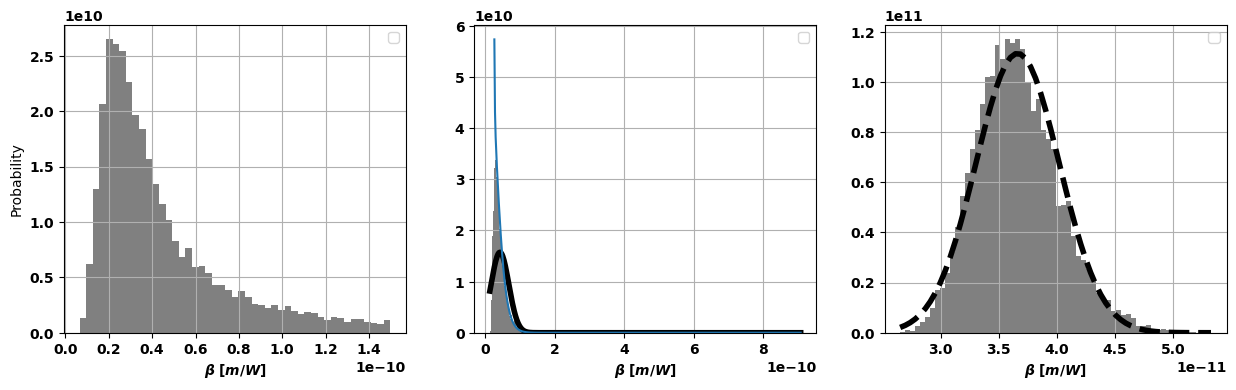

In [15]:
f=plt.figure(figsize=(15,4))

plt.subplot(131)
pars=np.ones(9)
beta_hist=np.array(dist_betas(10000,pars,0.8e-3))
borr=[]
for i in range(len(beta_hist)):
    if beta_hist[i]>15e-11:
        borr.append(i)

beta_hist=np.delete(beta_hist,borr)
#print('Criterio de gaussianidad: ',confirm_gauss(beta_hist))
(mu, sigma) = norm.fit(beta_hist)
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='gray')
plt.ylabel('Probability')
plt.xlabel(r'$\beta$ $[m/W]$')
#plt.title(r'$\mathrm{Histogram:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
plt.legend()


plt.subplot(132)
pars=np.zeros(9)
pars[4]=1
beta_hist=np.array(dist_betas(10000,pars,0.4e-3))
print('Criterio de gaussianidad: ',confirm_gauss(beta_hist))
#print('Criterio de gaussianidad: ',confirm_gauss(beta_hist))
(mu, sigma) = norm.fit(beta_hist)
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='gray')
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'k', linewidth=4)
err=0.4e-3
plt.plot(bins,real(bins,err))
mu=BETA(T_e[index],focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)+c2*err**2

plt.xlabel(r'$\beta$ $[m/W]$')
#plt.title(r'$\mathrm{Histogram:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
plt.legend()


plt.subplot(133)

pars=np.zeros(9)
pars[4]=1
beta_hist=np.array(dist_betas(10000,pars,0.1e-3))
borr=[]
for i in range(len(beta_hist)):
    if beta_hist[i]>10e-11:
        borr.append(i)

beta_hist=np.delete(beta_hist,borr)
(mu, sigma) = norm.fit(beta_hist)
#l = plt.plot(bins, y, '--k', linewidth=4)
err=0.1e-3
print('Criterio de gaussianidad: ',confirm_gauss(beta_hist))
#(mu, sigma) = norm.fit(beta_hist)
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='gray')
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, '--k', linewidth=4)
mu=BETA(T_e[index],focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)+c2*err**2
sigma=np.sqrt(err-3**2*c1**2+c2**2*(3**err-3**4-err-3**2))
plt.grid(True)
plt.legend()
plt.xlabel(r'$\beta$ $[m/W]$')





In [122]:
np.std(beta_hist)*1e11

0.4371413403465237

In [56]:
def nmoment(x, counts, c, n):
    return np.sum(counts*(x-c)**n) / np.sum(counts)

31

In [57]:
nmoment(bins, n, 0, 1)

ValueError: operands could not be broadcast together with shapes (31,) (32,) 

In [50]:
from scipy import stats
stats.moment(n, moment = 2)

3.1145778112158546e+18

In [47]:
mu=BETA(T_e[index],focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)+c2*0.8e-3**2
mu

6.345523340219129e-10

In [7]:
# Función ajustar
def BETA2(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    h=1
    r=-1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    b=sum(r[i]*(trans[i]-h) for i in range(len(trans)))/sum(r[i]**2 for i in range(len(trans)))
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b

def dist_betas2(N): 
    '''
    Implementación de protocolo de ajuste para el calculo de beta
    usando como metrica de ajuste el $\chi$²

    Parametros
    ----------
    T_ruido: Arreglo
        Arreglo con Datos ajustar.
    focal: Arreglo
        Arreglo con distancias focales utilizadas.
    ruido: Número
        Ruido que se le ha añadido a la señal teorica.

    La función devuelve el mejor valor de TPA y su error estandar
    '''
  # Contedra valores de TPA
    TPA=[]
    
    TT=T_e
    trans_f=T_e
    focal_f=focal
    for ii in range(N):
        
        er_L=0.01e-3
        er_P=5e-3
        er_T=0.3e-15
        er_wl=1e-9
        er_D=0
        er_ds=0.5e-3
        er_Cf=0.04
        er_a=37
        er_R=0.005
        er_freq=0
        er_trans=0
        er_focal=0

        # Randomly chosen parameters, normal distribution
        L_f = np.random.normal(L,er_L,1) # # thickness in (m).
        Pavg_f = np.random.normal(Pavg,er_P,1) # Average power in (W)
        Tp_f = abs(np.random.normal(Tp,er_T,1)) # Pulse width FWHM in (s). sech
        wl_f = np.random.normal(wl,er_wl,1) #central wavelength in (m)
        D_f = np.random.normal(D,er_D,1) # beam diameter in (m)
        ds_f = np.random.normal(ds,er_ds,1) # EFTL-sample distance (m)
        Cf_f = np.random.normal(Cf,er_Cf,1) # Beam correction factor
        alfa_f =  abs(np.random.normal(alfa,er_a,1)) #linear absorption (1/m)
        R_f = np.random.normal(R,er_R,1) # Reflectance
        freq_f = np.random.normal(freq,er_freq,1) # Reflectance
        
        
        TPA.append(BETA2(trans_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,ds_f,Cf_f,alfa_f,R_f,freq_f))
        
        
    return TPA


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Criterio de gaussianidad:  1


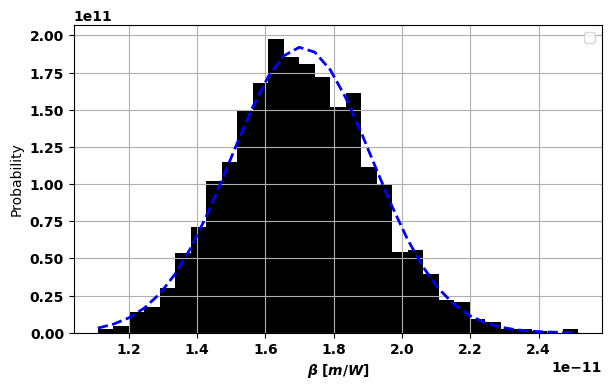

In [8]:
f=plt.figure(figsize=(15,4))

params=np.ones(12)
plt.subplot(121)

beta_hist=np.array(dist_betas2(1900))
print('Criterio de gaussianidad: ',confirm_gauss(beta_hist))
(mu, sigma) = norm.fit(beta_hist)
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='black')
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'b--', linewidth=2)
plt.ylabel('Probability')
plt.xlabel(r'$\beta$ $[m/W]$')
#plt.title(r'$\mathrm{Histogram:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
plt.legend()

